# Application of Word2Vec on top of Lemmatization using feature extractions -- Model Building

### Intro:
> Word2Vec is a popular word embedding technique used in natural language processing (NLP) to represent words as dense, continuous vectors in a high-dimensional space(Vector space). It was introduced by Tomas Mikolov et al. at Google in 2013 and has since become widely adopted for various NLP tasks.

### Idea of Word2Vec:
> The underlying principle of Word2Vec is to learn word embeddings by predicting the context in which words appear. It leverages the distributional hypothesis, which suggests that words appearing in similar contexts tend to have similar meanings. Word2Vec can be trained using two main architectures: Continuous Bag-of-Words (CBOW) and Skip-gram.

### Ways of Training:
>> Continuous Bag-of-Words (CBOW): In CBOW, the model aims to predict a target word based on its surrounding context words.

>> Skip-gram: Skip-gram is the inverse of CBOW. It predicts the surrounding context words given a target word.

>  **Here in this Project we are following the CBOW - Continuous Bag-of-Words approach because given  context of words we have to predict the target label based on the similarity among the context of words.**

## Import required libraries and install required modules

In [1]:
#!pip install distance

In [2]:
#! pip install fuzzywuzzy

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import f1_score, classification_report, confusion_matrix,accuracy_score

## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import nltk
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import distance
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from fuzzywuzzy import fuzz

[nltk_data] Downloading package stopwords to C:\Users\GUDLA
[nltk_data]     RAGUWING\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to C:\Users\GUDLA
[nltk_data]     RAGUWING\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to C:\Users\GUDLA
[nltk_data]     RAGUWING\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nlp_df = pd.read_csv(r"D:\Deep_learning\internship_pdf,docs\train_unzipped\Dataset.csv")

In [7]:
nlp_df.shape[0]

404290

In [4]:
nlp_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
nlp_df = nlp_df.dropna(how="any").reset_index(drop=True)

In [6]:
#Number of Unique Questions

qids = pd.Series(nlp_df['qid1'].tolist() + nlp_df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_greaterthan1 = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_greaterthan1,qs_greaterthan1/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157



## Feature Engineering

> Feature engineering is one of the profound way to extract meaningful features from the already existing features. There is a lot of scope for feature engineering in this project. Let's explore and find ways in which we can find the similarity between two questions.

In [8]:
nlp_df1 = nlp_df[['question1','question2','is_duplicate']]

In [9]:
nlp_df1.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Text to Numerical vectors - Word2Vec
* Step 1 - Import `Word2Vec` module from `gensim.models`
* Step 2 - Convert the sentences to the List of Words (i.e. List of Tokens)
* Step 3 - Use Word2Vec to learn numerical vectors for each `unique words`. Word2Vec uses the list of tokens and generate 300 Dimensional numerical vector for each unique word.
* Step 4 - Convert the word vectors to document vectors.

### Text to word embeddings(vectors)
> For the various text similarity calculations, we need to convert the texts to the representable embedding vectors on which distances could be calculated. We could use Gensim Google Word2Vec which embeds each word to `300` dimension vector.We could also create our own embedding. For simplicity we use Gensim Word2Vec which is based on huge corpus of text. Let's load it !!

In [3]:
import gensim
from gensim.models import Word2Vec

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format("D:\GoogleNews-vectors-negative300.bin", binary=True)

In [11]:
def Text2vec(s):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", s)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens = word_tokenize(sentence)
    
    # remove stop words                
    words = [t for t in tokens if not t in stopwords.words("english")]
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    V = []
    for w in words:#loop through each word in the sentence
        try:
            V.append(model[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(V) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [12]:
from tqdm import tqdm_notebook #for parallel processing

question1_vectors = np.zeros((nlp_df1.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(nlp_df1.question1.values)):
    question1_vectors[i, :] = Text2vec(q) #function call for each question 1
    
question2_vectors  = np.zeros((nlp_df1.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, q in enumerate(tqdm_notebook(nlp_df1.question2.values)):
    question2_vectors[i, :] = Text2vec(q) #function call for each question 2

C:\Users\GUDLA RAGUWING\AppData\Local\Temp\ipykernel_19340\3098498414.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(nlp_df1.question1.values)):


  0%|          | 0/404287 [00:00<?, ?it/s]

C:\Users\GUDLA RAGUWING\AppData\Local\Temp\ipykernel_19340\3567570112.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum
C:\Users\GUDLA RAGUWING\AppData\Local\Temp\ipykernel_19340\3098498414.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(nlp_df1.question2.values)):


  0%|          | 0/404287 [00:00<?, ?it/s]

In [13]:
vectorsQ1 = question1_vectors #300-dim vector representing the first question in question 1 coulumn.
vectorsQ2 = question2_vectors

In [15]:
from pickle import dump

dump(vectorsQ1, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\vectorsQ1.pkl", 'wb'))
dump(vectorsQ2, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\vectorsQ2.pkl", 'wb'))

In [16]:
from pickle import load
vectorsQ1 = load(open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\vectorsQ1.pkl", 'rb'))
vectorsQ2 = load(open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\vectorsQ2.pkl", 'rb'))

## Let's do feature engineering to extract distances

## Let's Learn little bit about distances

#### Cosine distance
* It is the compliment of the cosine similarity. Cosine similarity finds the angle between two text vectors in higher dimensional space. If cos(theta) is small then the cosine distance is large and vice-versa. Hence Inversly proportional. 
> Cosine distance = 1 - Cosine similarity

#### Mahattan or City-block distance
* Manhattan Distance is preferred over the Euclidean distance metric as the dimension of the data increases. This occurs due to something known as the ‘curse of dimensionality’.

#### Jaccard distance
* It is defined as size of intersection divided by size of union of two sets.

#### Fuzz_ratio
* It is a ratio function that computes the standard Levenshtein distance similarity ratio between two sequences.

#### Fuzz_partial_ratio
* This function allows us to perform substring matching. This works by taking the shortest string and matching it with all substrings that are of the same length.

#### Fuzz_token_sort_ratio
* This function sorts the strings alphabetically and then joins them together. Then, the fuzz.ratio() is calculated. This can come in handy when the strings you are comparing are the same in spelling but are not in the same order.

#### Fuzz_token_set_ratio
* The token_set_ratio() function is similar to the token_sort_ratio() function above, except it takes out the common tokens before calculating the fuzz.ratio() between the new strings. This function is the most helpful when applied to a set of strings with a significant difference in lengths.

In [17]:
nlp_df1['len_q1'] = nlp_df1.question1.apply(lambda x: len(str(x)))
nlp_df1['len_q2'] = nlp_df1.question2.apply(lambda x: len(str(x)))
nlp_df1['common_words'] = nlp_df1.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
nlp_df1['fuzz_ratio'] = nlp_df1.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['fuzz_partial_ratio'] = nlp_df1.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['fuzz_partial_token_set_ratio'] = nlp_df1.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['fuzz_partial_token_sort_ratio'] = nlp_df1.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['fuzz_token_set_ratio'] = nlp_df1.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['fuzz_token_sort_ratio'] = nlp_df1.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
nlp_df1['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]
nlp_df1['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]
nlp_df1['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]
nlp_df1['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]
nlp_df1['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]
nlp_df1['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(vectorsQ1), np.nan_to_num(vectorsQ2))]

C:\Users\GUDLA RAGUWING\AppData\Local\Temp\ipykernel_19340\1506494924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df1['len_q1'] = nlp_df1.question1.apply(lambda x: len(str(x)))
C:\Users\GUDLA RAGUWING\AppData\Local\Temp\ipykernel_19340\1506494924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df1['len_q2'] = nlp_df1.question2.apply(lambda x: len(str(x)))
D:\Anaconda\lib\site-packages\scipy\spatial\distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 

In [18]:
nlp_df1.to_csv('final_text_features.csv')

In [10]:
df = pd.read_csv(r"C:\Users\GUDLA RAGUWING\Data Science Course\Internship_Project\final_text_features.csv",index_col=[0])

In [11]:
df.head()

,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,jaccard_distance,euclidean_distance,minkowski_distance
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,10,93,98,100,88,100,93,94.023324,0.068972,5.081614,1.0,0.371408,0.168999
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,4,65,73,100,73,86,63,155.349837,0.307825,10.954625,1.0,0.784634,0.354073
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,4,45,41,100,71,63,63,135.988707,0.222009,9.055989,1.0,0.666346,0.307828
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,0,7,20,32,30,28,24,191.543720,0.654169,15.913837,1.0,1.143826,0.509155
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,2,37,54,100,67,67,47,161.408435,0.369993,12.103178,1.0,0.860225,0.382770


In [12]:
df.drop(['question1','question2'],axis = 1,inplace = True)

In [13]:
df.head()

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,jaccard_distance,euclidean_distance,minkowski_distance
0,0,66,57,10,93,98,100,88,100,93,94.023324,0.068972,5.081614,1.0,0.371408,0.168999
1,0,51,88,4,65,73,100,73,86,63,155.349837,0.307825,10.954625,1.0,0.784634,0.354073
2,0,73,59,4,45,41,100,71,63,63,135.988707,0.222009,9.055989,1.0,0.666346,0.307828
3,0,50,65,0,7,20,32,30,28,24,191.543720,0.654169,15.913837,1.0,1.143826,0.509155
4,0,76,39,2,37,54,100,67,67,47,161.408435,0.369993,12.103178,1.0,0.860225,0.382770


In [14]:
df.isna().sum()

is_duplicate                     0
len_q1                           0
len_q2                           0
common_words                     0
fuzz_ratio                       0
fuzz_partial_ratio               0
fuzz_partial_token_set_ratio     0
fuzz_partial_token_sort_ratio    0
fuzz_token_set_ratio             0
fuzz_token_sort_ratio            0
canberra_distance                0
cosine_distance                  0
cityblock_distance               0
jaccard_distance                 0
euclidean_distance               0
minkowski_distance               0
dtype: int64

In [15]:
df = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','jaccard_distance','euclidean_distance',
                'minkowski_distance','is_duplicate']] # Reanrrange the features

In [16]:
df.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,jaccard_distance,euclidean_distance,minkowski_distance,is_duplicate
0,66,57,10,93,98,88,100,93,94.023324,0.068972,5.081614,1.0,0.371408,0.168999,0
1,51,88,4,65,73,73,86,63,155.349837,0.307825,10.954625,1.0,0.784634,0.354073,0
2,73,59,4,45,41,71,63,63,135.988707,0.222009,9.055989,1.0,0.666346,0.307828,0
3,50,65,0,7,20,30,28,24,191.543720,0.654169,15.913837,1.0,1.143826,0.509155,0
4,76,39,2,37,54,67,67,47,161.408435,0.369993,12.103178,1.0,0.860225,0.382770,0


In [17]:
y = df['is_duplicate'] # Seggregating the data to input and output
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

In [18]:
from sklearn.model_selection import train_test_split # Test - Train 
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# scaling the numerical features on the Training Data
from sklearn.preprocessing import StandardScaler

Std_scaler = StandardScaler()

# feature names will be (annoyingly) lost after Scaling the data
# (i.e. the dataframe is converted to a numpy ndarray)

X_train_trns = pd.DataFrame(Std_scaler.fit_transform(X_train),
                                     columns = X_train.columns,
                                     index = X_train.index)
X_train_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
140907,1.617137,-0.593471,-1.456762,-1.229783,-0.690771,-0.588713,-1.480158,-1.370861,1.022918,1.399068,1.292268,1.276023,1.254357
107095,3.820046,4.937152,2.741784,-2.051324,-1.166366,-0.708375,-0.558191,-2.838418,-0.072420,-0.493071,-0.296929,-0.296154,-0.293696
27940,0.649192,0.974032,2.418819,1.508688,1.634363,0.428413,1.140171,1.144952,-0.499967,-0.817826,-0.699323,-0.732175,-0.745317
157099,-0.085111,-0.179414,0.803993,0.550223,0.313264,0.488244,0.072629,0.515999,0.245175,-0.170939,0.065661,0.052460,0.053212
111381,0.782701,1.240211,0.158063,-0.271318,-0.268019,-0.169896,0.024105,0.149109,-0.059704,-0.438108,-0.232388,-0.232171,-0.226644


In [41]:
X_test_trns = pd.DataFrame(Std_scaler.transform(X_test),
                                    columns = X_test.columns,
                                    index = X_test.index)
X_test_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
8067,-0.852792,-0.770924,0.803993,1.371764,1.317299,1.445540,0.897548,0.987714,-0.442651,-0.682330,-0.526276,-0.535825,-0.532135
224277,-0.652528,0.086766,-1.133797,-1.412348,-0.637927,-0.887868,-0.800814,-0.741908,0.379060,0.335164,0.501046,0.509233,0.509141
252450,-0.485640,1.713420,-0.810832,-1.138501,-0.373707,-0.289558,-0.897863,-1.318448,0.975178,1.226165,1.129551,1.163524,1.200766
174038,-0.385508,1.979600,-1.456762,-1.640554,-1.430586,-1.546009,-1.868355,-1.580512,1.292478,2.358440,1.805498,1.842986,1.840384
384860,-0.719282,0.027615,0.158063,0.504582,-0.109487,0.607906,0.800498,0.201522,0.046866,-0.187846,-0.033237,0.035550,0.081342


## Model Building

## LogisticRegression

In [42]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()
cls.fit(X_train_trns, y_train)

# prediction on train
y_train_pred = cls.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# prediction on test
y_test_pred = cls.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

LogisticRegression()

---------- Prediction on train ----------
[[133274  45141]
 [ 49522  55063]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74    178415
           1       0.55      0.53      0.54    104585

    accuracy                           0.67    283000
   macro avg       0.64      0.64      0.64    283000
weighted avg       0.66      0.67      0.66    283000

---------- Prediction on test ----------
[[57194 19415]
 [21147 23531]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     76609
           1       0.55      0.53      0.54     44678

    accuracy                           0.67    121287
   macro avg       0.64      0.64      0.64    121287
weighted avg       0.66      0.67      0.66    121287



## RidgeClassifier -- Hyperparameter tuning of LR

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier

tuned_parameters = [{'alpha':[x for x in range(1,10)]}]

clf = GridSearchCV(
    estimator=RidgeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trns, y_train)

print("Best parameters set found on train set:")
print(clf.best_params_)
print(clf.best_estimator_)

y_p = clf.predict(X_test_trns)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid=[{'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='f1', verbose=1)

Best parameters set found on train set:
{'alpha': 2}
RidgeClassifier(alpha=2)


In [44]:
# Evaluating the model using the Evaluation metrics
print(f1_score(y_test, y_p)) 
print(classification_report(y_test, y_p))

0.5122797016768799
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     76609
           1       0.55      0.48      0.51     44678

    accuracy                           0.66    121287
   macro avg       0.63      0.62      0.63    121287
weighted avg       0.65      0.66      0.66    121287



## AdaBoostClassifier

In [45]:
from sklearn.ensemble import AdaBoostClassifier
cls1 = AdaBoostClassifier()
cls1.fit(X_train_trns, y_train)

# prediction on train
y_train_pred1 = cls1.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred1))
print(classification_report(y_train, y_train_pred1))

# prediction on test
y_test_pred1 = cls1.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred1))
print(classification_report(y_test, y_test_pred1))

AdaBoostClassifier()

---------- Prediction on train ----------
[[129771  48644]
 [ 34140  70445]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76    178415
           1       0.59      0.67      0.63    104585

    accuracy                           0.71    283000
   macro avg       0.69      0.70      0.69    283000
weighted avg       0.72      0.71      0.71    283000

---------- Prediction on test ----------
[[55670 20939]
 [14525 30153]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     76609
           1       0.59      0.67      0.63     44678

    accuracy                           0.71    121287
   macro avg       0.69      0.70      0.69    121287
weighted avg       0.72      0.71      0.71    121287



## GradientBoostingClassifier

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
cls2 = GradientBoostingClassifier()
cls2.fit(X_train_trns, y_train)

# prediction on train
y_train_pred2 = cls2.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))

# prediction on test
y_test_pred2 = cls2.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred2))
print(classification_report(y_test, y_test_pred2))

GradientBoostingClassifier()

---------- Prediction on train ----------
[[132066  46349]
 [ 30430  74155]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77    178415
           1       0.62      0.71      0.66    104585

    accuracy                           0.73    283000
   macro avg       0.71      0.72      0.72    283000
weighted avg       0.74      0.73      0.73    283000

---------- Prediction on test ----------
[[56708 19901]
 [12948 31730]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78     76609
           1       0.61      0.71      0.66     44678

    accuracy                           0.73    121287
   macro avg       0.71      0.73      0.72    121287
weighted avg       0.74      0.73      0.73    121287



## XGBClassifier

In [47]:
from xgboost import XGBClassifier
cls3 = XGBClassifier()
cls3.fit(X_train_trns, y_train)

# prediction on train
y_train_pred3 = cls3.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred3))
print(classification_report(y_train, y_train_pred3))

# prediction on test
y_test_pred3 = cls3.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred3))
print(classification_report(y_test, y_test_pred3))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

---------- Prediction on train ----------
[[136949  41466]
 [ 27627  76958]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80    178415
           1       0.65      0.74      0.69    104585

    accuracy                           0.76    283000
   macro avg       0.74      0.75      0.74    283000
weighted avg       0.76      0.76      0.76    283000

---------- Prediction on test ----------
[[57959 18650]
 [12541 32137]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     76609
           1       0.63      0.72      0.67     44678

    accuracy                           0.74    121287
   macro avg       0.73      0.74      0.73    121287
weighted avg       0.75      0.74      0.75    121287



## Building a StackingClassifier model

In [48]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier(),
      'RC',RidgeClassifier(),
     'RF',RandomForestClassifier(),
     'GBDT',GradientBoostingClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=XGBClassifier())

stack_cls.fit(X_train_trns, y_train)


# Prediction on test data
y_test_pred4 = stack_cls.predict(X_test_trns)

print('-'*10,'on test','-'*10)
# Evaluation on test data
print(confusion_matrix(y_test, y_test_pred4))
print(classification_report(y_test, y_test_pred4))

StackingClassifier(estimators=[('LR', LogisticRegression()),
                               ('GNB', GaussianNB()),
                               ('DT', DecisionTreeClassifier(random_state=42),
                                'XGb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None, ...))

---------- on test ----------
[[59261 17348]
 [18838 25840]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     76609
           1       0.60      0.58      0.59     44678

    accuracy                           0.70    121287
   macro avg       0.68      0.68      0.68    121287
weighted avg       0.70      0.70      0.70    121287



In [49]:
from pickle import dump

dump(cls, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\LR_cls.pkl", 'wb'))
dump(stack_cls, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\stack_cls.pkl", 'wb'))
dump(clf, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\LR_HYP.pkl", 'wb'))
dump(cls1, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\ADA_cls.pkl", 'wb'))
dump(cls2, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\GBDT_cls.pkl", 'wb'))
dump(cls3, open(r"D:\Deep_learning\internship project\W2V_distcance\vectors\XGB_cls.pkl", 'wb'))

## calibration_curve

In [6]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

CalibratedClassifierCV(cv=5, estimator=SGDClassifier(loss='log_loss', tol=0.01),
                       method='isotonic')

D:\Anaconda\lib\site-packages\sklearn\calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Text(0.5, 0, 'Average Prob')

Text(0, 0.5, 'Fraction of positive')

Text(0.5, 1.0, 'Calibration plot (isotonic)')

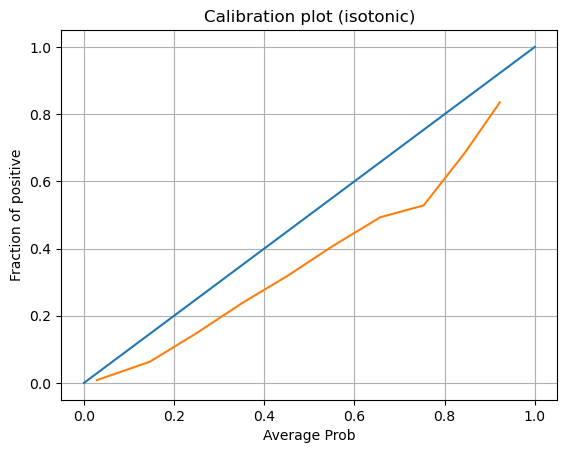

In [19]:
clf = SGDClassifier(penalty = 'l2',alpha = 0.0001,tol = 0.01,loss = 'log_loss')
calibrated_model = CalibratedClassifierCV(clf,method = 'isotonic',cv = 5)
calibrated_model.fit(X_train,y_train)
prob = calibrated_model.predict_proba(X_test)[:,1] #for one of the class
fop,apv  = calibration_curve(y_test,prob,n_bins = 10,normalize = True)
plt.plot([0,1],[0,1])
plt.plot(apv,fop)
plt.grid()
plt.xlabel("Average Prob")
plt.ylabel("Fraction of positive")
plt.title('Calibration plot (isotonic)')
plt.show()
#The calibration is not exactly ideal but pretty-good.

CalibratedClassifierCV(cv=5, estimator=SGDClassifier(loss='log_loss', tol=0.01))

D:\Anaconda\lib\site-packages\sklearn\calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


Text(0.5, 0, 'Average Prob')

Text(0, 0.5, 'Fraction of positive')

Text(0.5, 1.0, 'Calibration plot (Sigmoid)')

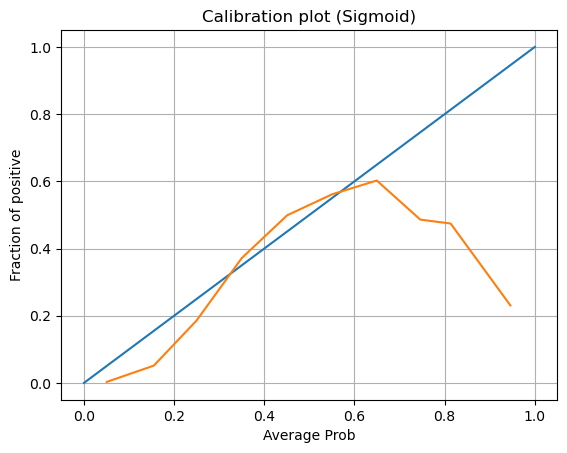

In [20]:
clf = SGDClassifier(penalty = 'l2',alpha = 0.0001,tol = 0.01,loss = 'log_loss')
calibrated_model = CalibratedClassifierCV(clf,method = 'sigmoid',cv = 5)
calibrated_model.fit(X_train,y_train)
prob = calibrated_model.predict_proba(X_test)[:,1] #for one of the class
fop,apv  = calibration_curve(y_test,prob,n_bins = 10,normalize = True)
plt.plot([0,1],[0,1])
plt.plot(apv,fop)
plt.grid()
plt.xlabel("Average Prob")
plt.ylabel("Fraction of positive")
plt.title('Calibration plot (Sigmoid)')
plt.show()

# MLOP's --- Model Experiment Tracking

* MLOps, short for Machine Learning Operations, refers to the practices and tools used to streamline and operationalize machine learning models in production environments. 
* It combines elements of machine learning, software engineering, and operations to ensure the reliable and efficient deployment, monitoring, and management of machine learning systems or models.

> The primary goal of MLOps is to bridge the gap between the development and deployment of machine learning models, enabling organizations to scale their ML initiatives and derive value from their models in real-world scenarios.

In [5]:
#pip install mlflow

## Experiment Tracking - 1 XGBOOST

In [7]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier = XGBClassifier()
classifier.fit(X_train_transformed, y_train)
y_test_predicted = classifier.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 12:13:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 12:13:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 12:13:10 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2023/06/07 12

## Experiment Tracking - 2 AdaBoostClassifier

In [13]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier1 = AdaBoostClassifier()
classifier1.fit(X_train_transformed, y_train)
y_test_predicted = classifier1.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 12:31:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 12:31:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 12:31:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3facd08b773d4ff2990db01ea4f5ea27', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## Experiment Tracking - 2 GradientBoostingClassifier

In [15]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier2 = GradientBoostingClassifier()
classifier2.fit(X_train_transformed, y_train)
y_test_predicted = classifier1.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 12:44:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 12:44:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 12:44:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'efcaee04261c47a9a41025990ac68262', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## Experiment Tracking - 2 StackingClassifier

In [17]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=DecisionTreeClassifier())
#Training and Testing the data
stack_cls.fit(X_train_transformed, y_train)
y_test_predicted = stack_cls.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 13:00:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 13:00:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 13:00:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd3a9bf3b56134736a8007e09b6f06754', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/07 13:00:02 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('LR', LogisticRegression()), ('GNB', GaussianNB()), ('DT', DecisionTreeClassifier(random_state=42), 'XGb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_ty

## XgBoost Mlflow  Model Tracking Images

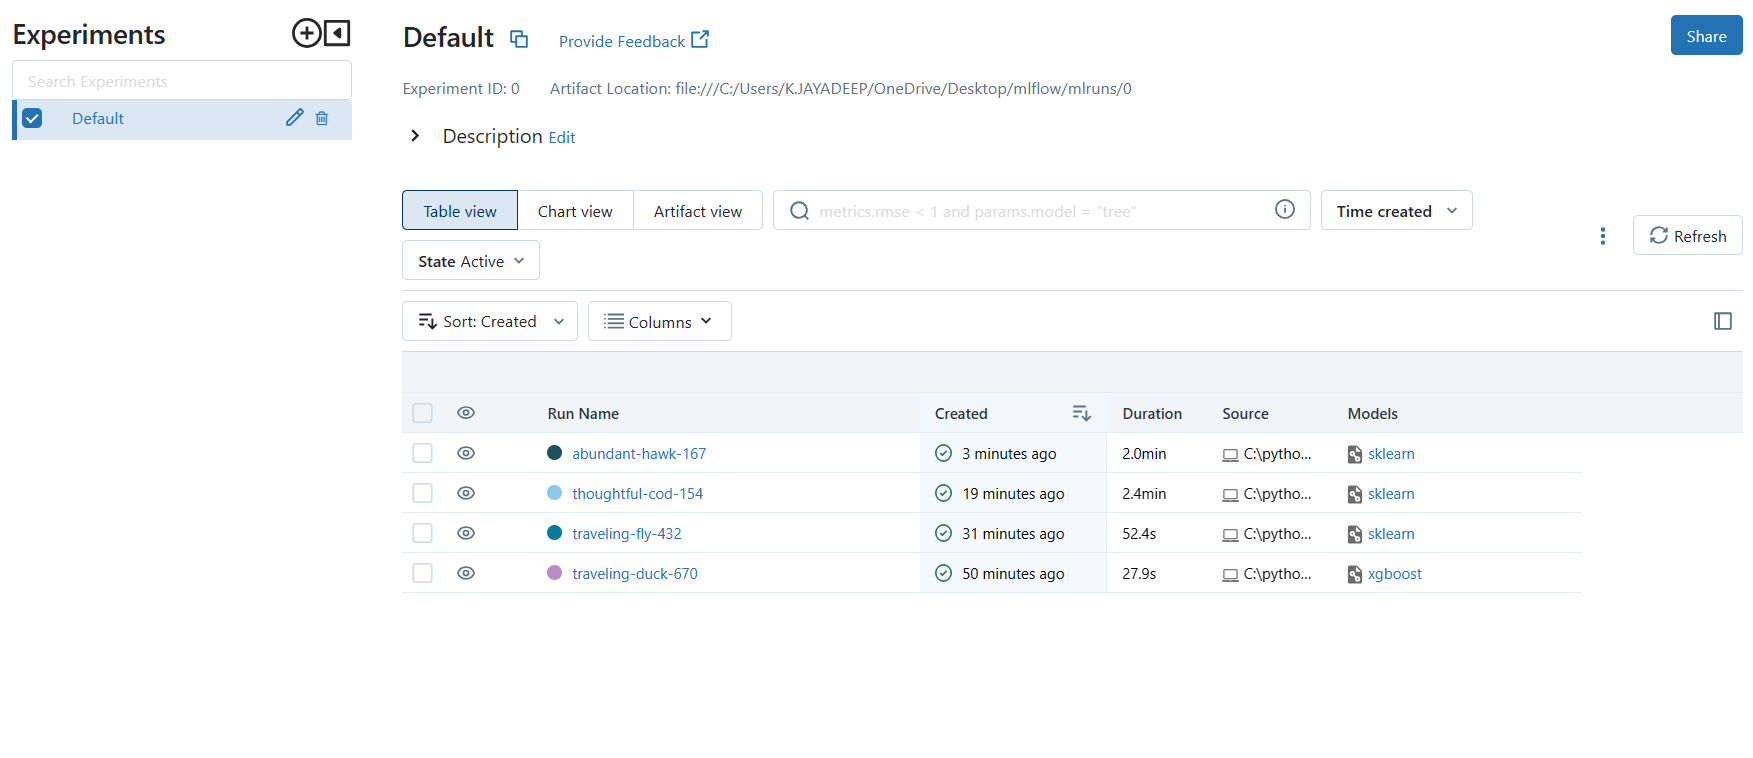

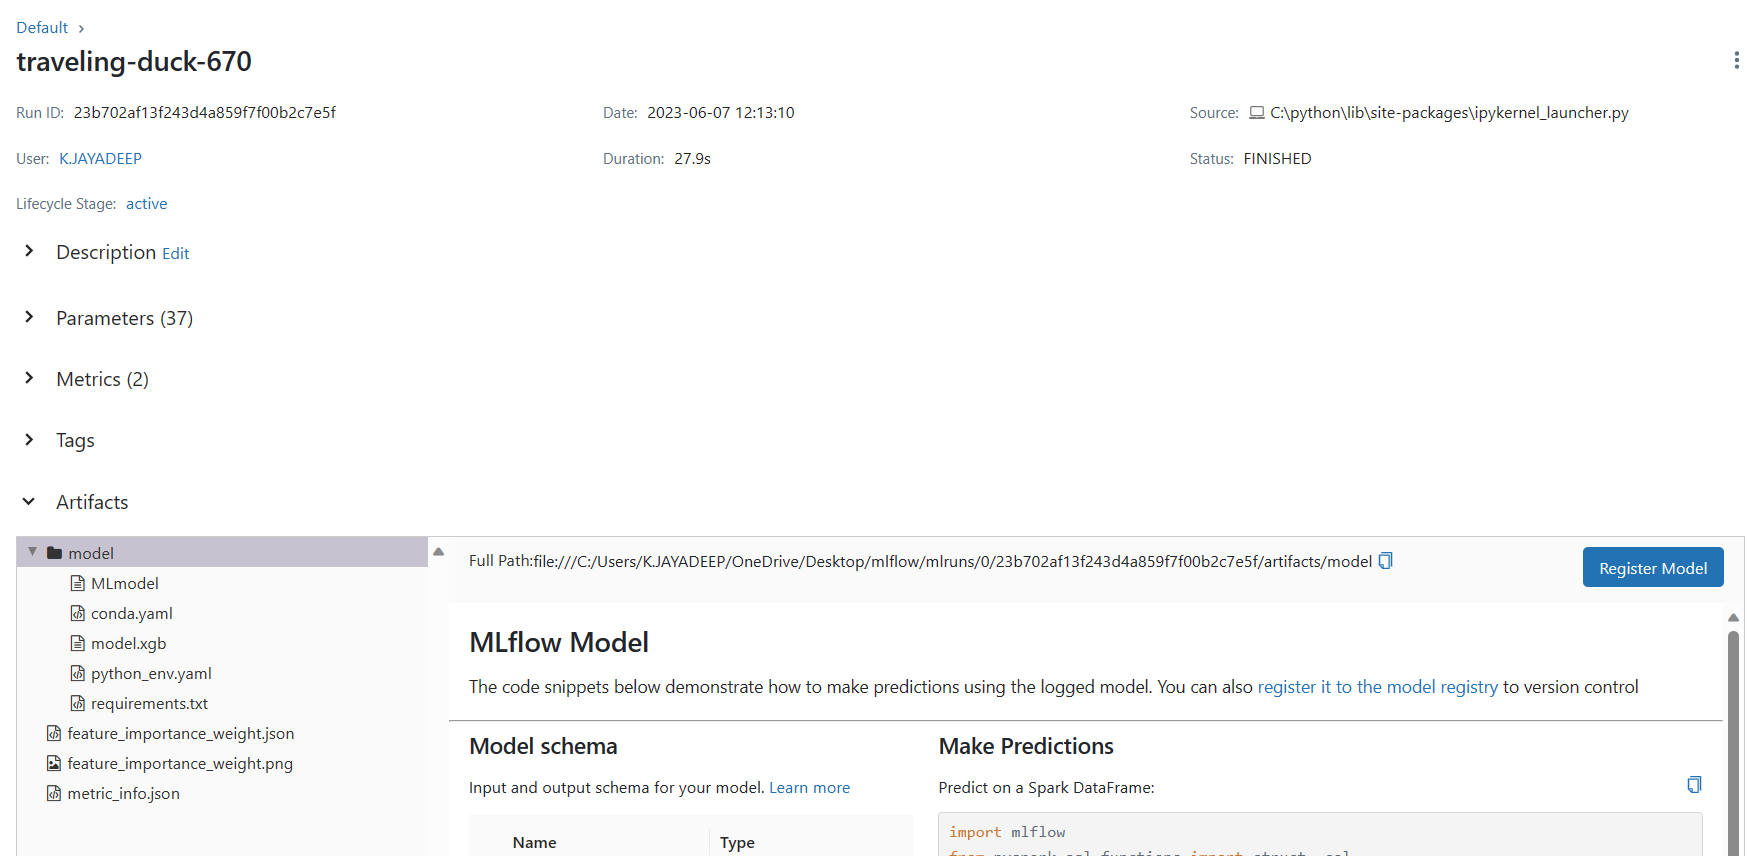

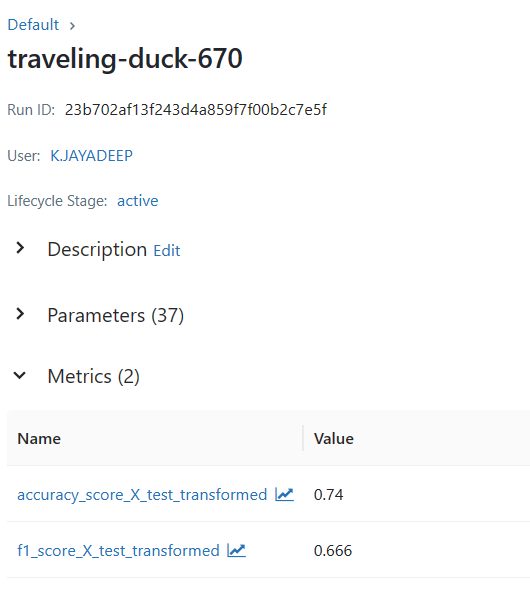

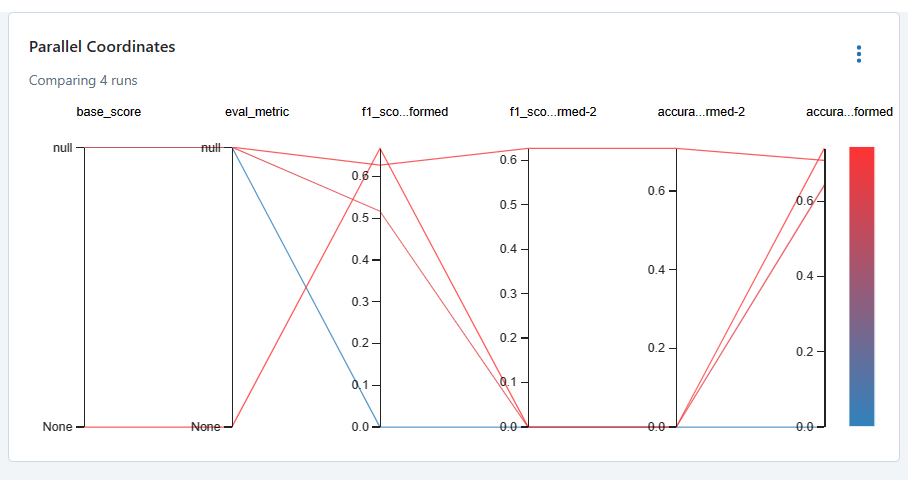

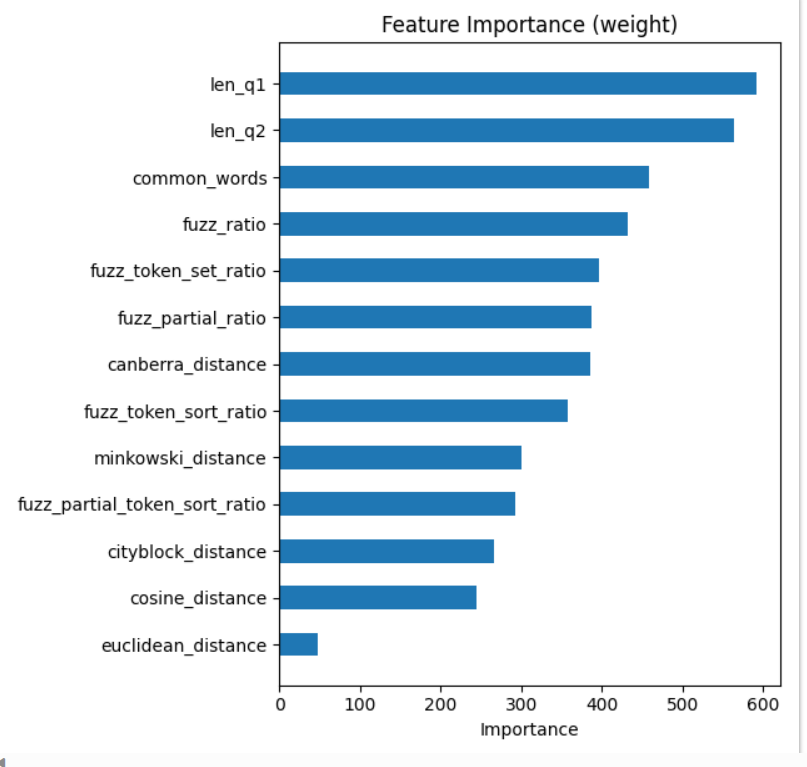

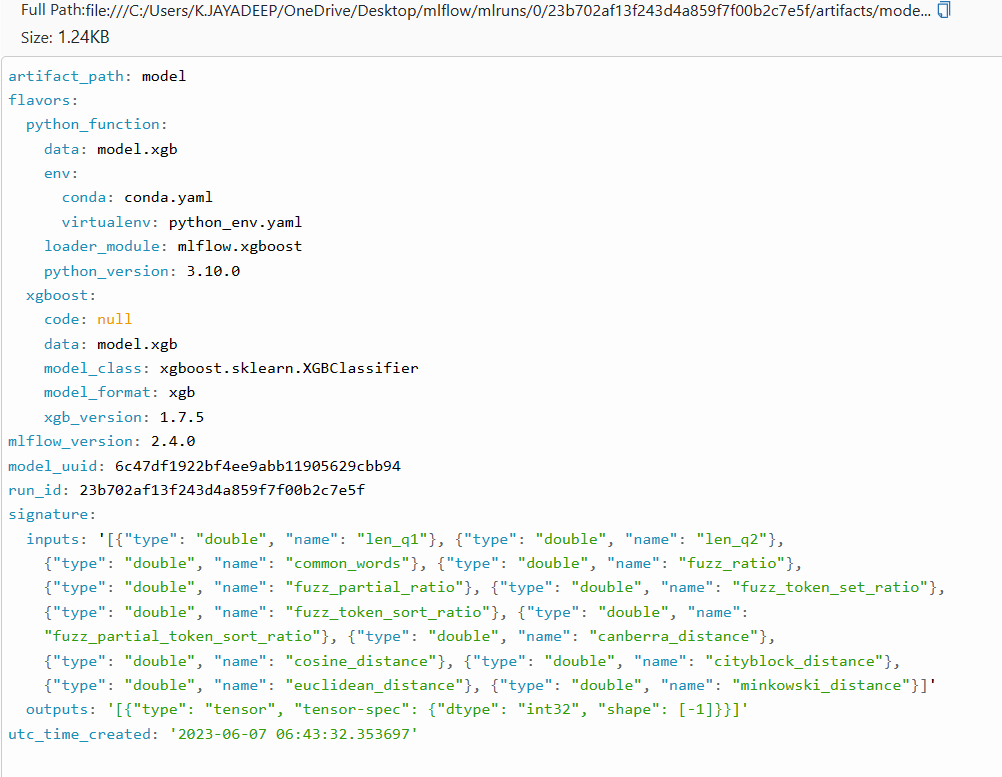

# Conclusions

- From all the models that we built, The Model Generated by `XgBoostClassifier` Algorithem is the best `Model` for Quora Question Pair SImilarity Problem.
- Evaluation Metric - F1 score on train - `non - duplicates is 80% and duplicates is 69%`
- Evaluation Metric - F1 score on test -  `non - duplicates is 79% and duplicates is 67%`
- Our model is predicting well the non duplicate questions with label 0 and was lacking in the prediction of duplicate questions with label 1, which you can notice from the f1 score.(There is a cost of mis-classification)
- Reason for mis-classification: Due to data imbalance(68% non-duplicates, 36% duplicates) and due to the random split of the data.
- We have performed mlops for model tracking using mlflow for all the models.